<a href="https://colab.research.google.com/github/kassymkhan0101/project_5/blob/master/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-2.0-preview


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from keras import optimizers

In [0]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

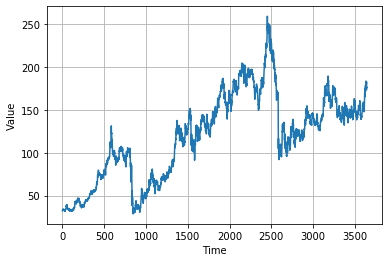

In [0]:
df= pd.read_csv("/content/drive/My Drive/Datasett/wolg.csv")
df.head()
# T=df['Date']
# A_p=df['Open']
# App = []
# Time = []
# for i in range(len(df)):
#   App.append(float(A_p[i]))
#   Time.append(str(T[i]))
# Time
# series =np.array(App)
# time = np.arange(0,len(series))
# plt.figure(figsize=(10, 6))
plot_series(time, series)


In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
x_valid.shape

(644,)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set= windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=26)
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast1 = rnn_forecast[split_time - window_size:-1, -1, 0]

Epoch 1/26
30/30 [==============================] - 7s 227ms/step - loss: nan - mae: nan
Epoch 2/26
30/30 [==============================] - 4s 144ms/step - loss: nan - mae: nan
Epoch 3/26
30/30 [==============================] - 4s 145ms/step - loss: nan - mae: nan
Epoch 4/26
30/30 [==============================] - 4s 146ms/step - loss: nan - mae: nan
Epoch 5/26
30/30 [==============================] - 4s 144ms/step - loss: nan - mae: nan
Epoch 6/26
30/30 [==============================] - 4s 146ms/step - loss: nan - mae: nan
Epoch 7/26
30/30 [==============================] - 4s 143ms/step - loss: nan - mae: nan
Epoch 8/26
30/30 [==============================] - 4s 145ms/step - loss: nan - mae: nan
Epoch 9/26
30/30 [==============================] - 4s 146ms/step - loss: nan - mae: nan
Epoch 10/26
30/30 [==============================] - 4s 146ms/step - loss: nan - mae: nan
Epoch 11/26
30/30 [==============================] - 4s 144ms/step - loss: nan - mae: nan
Epoch 12/26
30/30 [

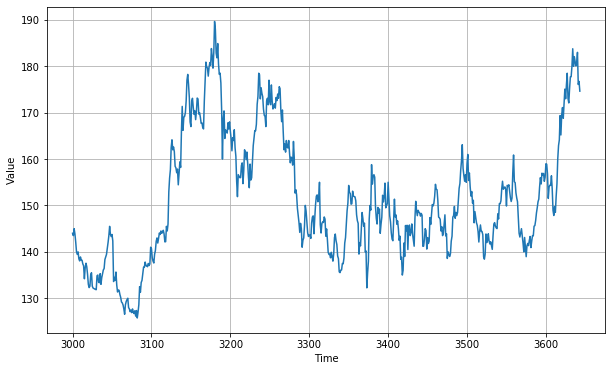

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid )
plot_series(time_valid, rnn_forecast1)

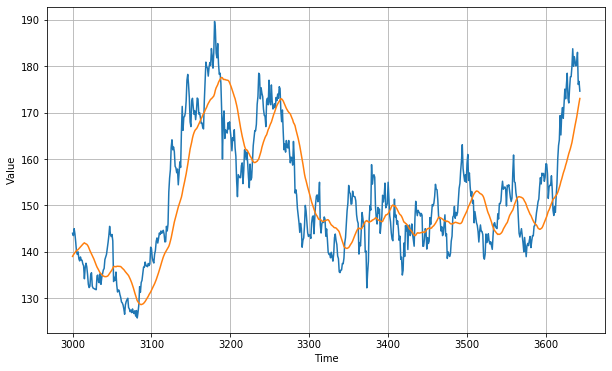

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid )
plot_series(time_valid, moving_avg)
plot_series(time_valid, rnn_forecast1)

In [0]:
def windowed_dataset5(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
dataset = windowed_dataset5(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=50,verbose=0)

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results3 = np.array(forecast)[:, 0, 0]

In [0]:
results3

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
def windowed_dataset1(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
dataset = windowed_dataset1(x_train, window_size, batch_size, shuffle_buffer_size)
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
  ])
optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model3.compile(loss="mse", optimizer=optimizer,metrics=["mae"])
history = model3.fit(dataset, epochs=50, verbose=1)

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model3.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid )
plot_series(time_valid, moving_avg)
plot_series(time_valid, rnn_forecast1)
plot_series(time_valid, results)
plot_series(time_valid, results3)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
def windowed_dataset2(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
dataset = windowed_dataset2(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model1.fit(dataset,epochs=50)

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model3.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results6 = np.array(forecast)[:, 0, 0]

In [0]:
def plot_series_color(time, series,color, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, )
plot_series(time_valid, moving_avg)
plot_series(time_valid, rnn_forecast1)
plot_series(time_valid, results)
plot_series(time_valid, results3)
plot_series(time_valid, results6)

In [0]:
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast1).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results3).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results6).numpy())